In [5]:
import sys
import scipy.io
import h5py
import numpy as np
import os, sys, time, subprocess, h5py, argparse, logging, pickle
import numpy as np
import pandas as pd
from os.path import join as oj
from copy import deepcopy
from scipy.ndimage import imread
import skimage
from PIL import Image
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path                   
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import data.data as data
import re

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# preprocess raw data

In [6]:
def read_conditions(fname):
    c_raw = pd.read_csv(fname, delimiter=',')
    c = pd.DataFrame() #pd.read_csv(oj('data', 'star_polymer_conditions.csv'), delimiter=',')
    c['fnames'] = c_raw.fnames.astype(str)
    c['conc'] = c_raw.conc_solution # mol/L
    c['solvent_glyc'] = [int(x[:2]) for x in c_raw.solvent_glyc]# percent glycerol, 5% ethanol, 85% water
    c['pressure'] = c_raw.pressure # mba  r
    c['time'] = c_raw.time # time delivered for (s)
    c['zmin'] = zz = [float(re.sub("[^0-9*.-]", "", zz).split('*')[0]) for zz in c_raw.zz] # physical width = physical height# max zscale
    c['zmax'] = zz = [float(re.sub("[^0-9*.-]", "", zz).split('*')[1]) for zz in c_raw.zz] # physical width = physical height# max zscale
    c['width_physical'] = [float(re.sub("[^0-9*.]", "", xy).split('*')[0]) for xy in c_raw.xy] # physical width = physical height
    c['R'] = c_raw.R # based on scan lines
    c['C'] = c_raw.C # based on scan lines
    return c
conditions = read_conditions(oj('data', 'star_polymer_conditions.csv'))

In [28]:
from lib.igg import binarywave
def read_ims(data_raw_dir, conditions):
    ims = []
    for fname in conditions['fnames']:
        try:
            data = binarywave.load(oj(data_raw_dir, fname + '.ibw'))['wave']
            ims.append(data['wData'][..., -1])
        except:
            print(fname)
    conditions['ims'] = ims
    return conditions

data_raw_dir = 'data/star_polymer/star_polymer_raw_ibw'
dset = read_ims(data_raw_dir, conditions)

# images 3 and 33 have strange artifacts which require removal
dset = dset.drop([3, 33], axis=0).reset_index()

# preprocess images
ims = deepcopy(dset.ims)
print('len', len(dset.ims))
for i in range(len(ims)):
    im = skimage.transform.resize(ims[i], (512, 512))
    im -= np.min(im)
    ims[i] = im

# outliers (indexes after dropping)
ims[21][ims[22] < 1e-8] = 1.17925154e-08 # image 21 has a couple very low points that ruin its contrast

dset.ims = ims

len 36


# plot all data

36


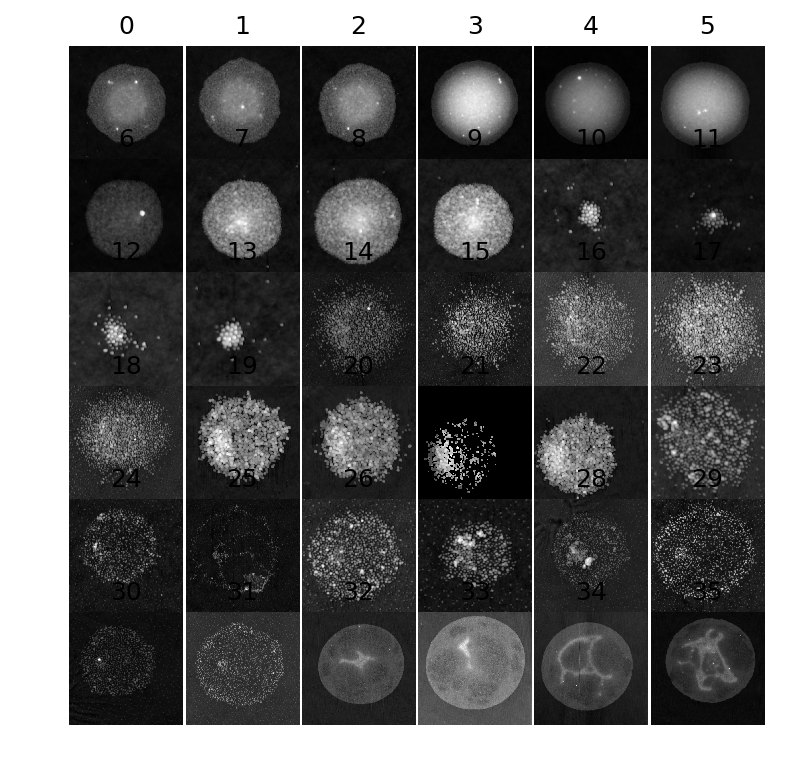

In [30]:
print(len(ims))
plt.figure(figsize=(6, 6), dpi=150)
R, C = 6, 6
for i in range(len(ims)):
    plt.subplot(R, C, i+1)
    im = ims[i]
    plt.imshow(im, cmap='gray')
#     plt.title(i)
    plt.axis('off')
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()